In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable("png") # for github specifically. comment it to make it interactive.

RendererRegistry.enable('png')

In [2]:
df = pd.read_csv('../data/movie_ratings.csv')

In [3]:
df.head()

,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,title,year,decade,genres,rating_year
0,196,242,3,1997-12-04 15:55:49,49,M,writer,55105,Kolya (1996),1996.0,1990.0,Comedy,1997
1,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),1997.0,1990.0,Crime,1998
2,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),1997.0,1990.0,Film-Noir,1998
3,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),1997.0,1990.0,Mystery,1998
4,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),1997.0,1990.0,Thriller,1998


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212595 entries, 0 to 212594
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      212595 non-null  int64  
 1   movie_id     212595 non-null  int64  
 2   rating       212595 non-null  int64  
 3   timestamp    212595 non-null  object 
 4   age          212595 non-null  int64  
 5   gender       212595 non-null  object 
 6   occupation   212595 non-null  object 
 7   zip_code     212595 non-null  object 
 8   title        212595 non-null  object 
 9   year         212559 non-null  float64
 10  decade       212559 non-null  float64
 11  genres       212595 non-null  object 
 12  rating_year  212595 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 21.1+ MB


**Convert timestamp to datetime**

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [6]:
df.isnull().sum()

user_id         0
movie_id        0
rating          0
timestamp       0
age             0
gender          0
occupation      0
zip_code        0
title           0
year           36
decade         36
genres          0
rating_year     0
dtype: int64

**What's the breakdown of genres for the movies that were rated?**

In [7]:
genres_df = df['genres'].value_counts().reset_index().rename({'index':'genre','genres':'count'}, axis = 1)

In [8]:
chart = alt.Chart(genres_df).mark_bar().encode(
    y=alt.Y('genre:N', sort=None, title='Genre'),   
    x=alt.X('count:Q', title='Count'),                  
    color='genre:N',
    tooltip=['genre', 'count']
).properties(
    title='Genres Distribution',
    width=800,
    height=400
)

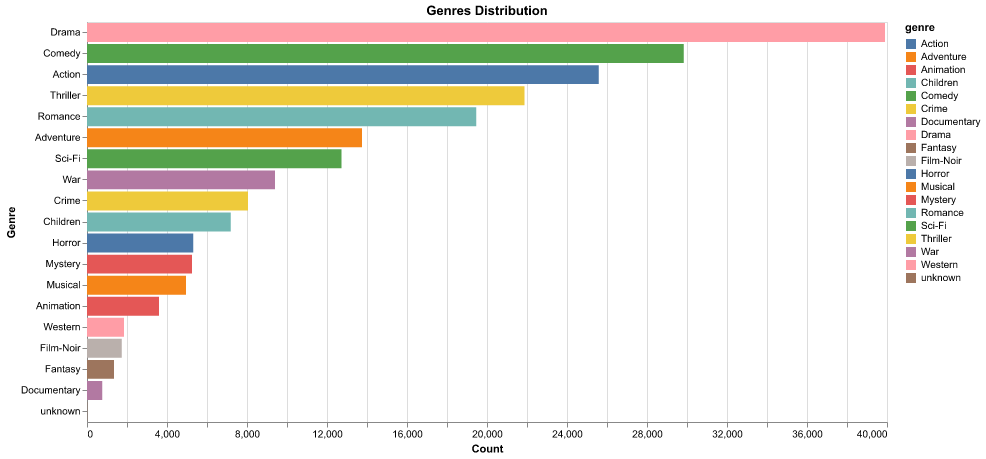

In [9]:
chart

**Which genres have the highest viewer satisfaction (highest ratings)?**

In [10]:
df['rating'].unique()

array([3, 1, 2, 4, 5], dtype=int64)

**Strategies** \
First Strategy is just caclulate average rating for each genre and find the one with the highest \
Second Strategy is choose genres with highest percentage of max rating = 5.

In [11]:
genres_avg_rating = df.groupby(['genres']).agg({'rating':'mean'}).reset_index().sort_values(by= 'rating', ascending=False)

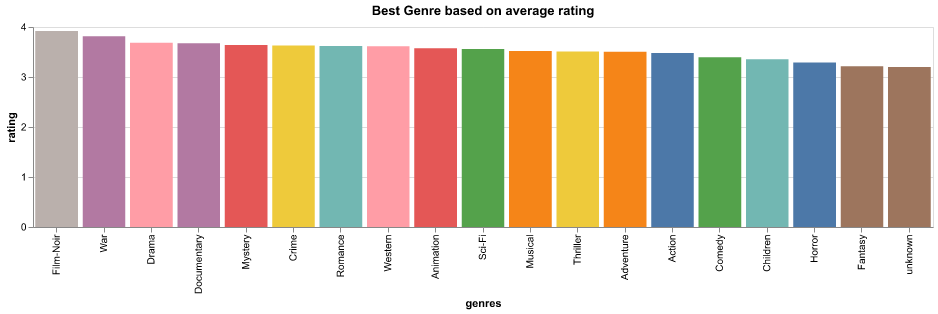

In [12]:
chart = alt.Chart(genres_avg_rating).mark_bar().encode(
    x=alt.X('genres:N', sort='-y'),   # sort bars by count
    y=alt.Y('rating:Q'),
    color=alt.Color('genres:N', legend=None),  # distinct colors per brand
    tooltip=['genres', 'rating']
).properties(
    title="Best Genre based on average rating",
    width=900,
    height=200
)

chart.show()

**second approach**

In [13]:
# Step 1: count total ratings per genre
total_counts = df.groupby("genres")["rating"].count()
# Step 2: count only 5-star ratings per genre
five_star_counts = df[df["rating"] == 5].groupby("genres")["rating"].count()
# Step 3: combine
best_genres = pd.DataFrame({
    "total_ratings": total_counts,
    "five_star_count": five_star_counts
}).fillna(0).reset_index()

best_genres['percentage'] = round(best_genres['five_star_count'] / best_genres['total_ratings'],2)
best_genres.sort_values(by = 'percentage', ascending = False)

,genres,total_ratings,five_star_count,percentage
9,Film-Noir,1733,560,0.32
16,War,9398,2914,0.31
6,Documentary,758,209,0.28
7,Drama,39895,9997,0.25
5,Crime,8055,1963,0.24
13,Romance,19461,4559,0.23
14,Sci-Fi,12730,2914,0.23
12,Mystery,5245,1225,0.23
2,Animation,3605,796,0.22
17,Western,1854,394,0.21


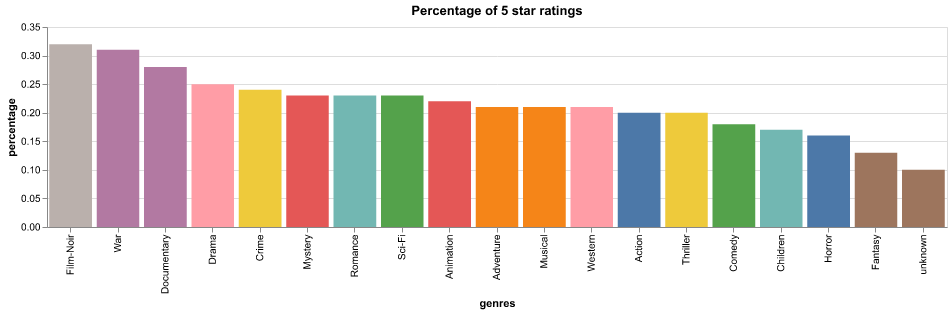

In [14]:
chart = alt.Chart(best_genres).mark_bar().encode(
    x=alt.X('genres:N', sort='-y'),   # sort bars by count
    y=alt.Y('percentage:Q'),
    color=alt.Color('genres:N', legend=None),  # distinct colors per brand
    tooltip=['genres', 'percentage']
).properties(
    title="Percentage of 5 star  ratings",
    width=900,
    height=200
)

chart.show()

**How does mean rating change across movie release years?**

In [15]:
df["year_month"] = df["timestamp"].dt.to_period("M").astype(str)

In [16]:
back_to_future = df[df['title'] == "Back to the Future (1985)"]

In [17]:
time_rating = back_to_future.groupby('year_month').agg({'rating':'mean'}).reset_index().sort_values(by = 'year_month', ascending = True)

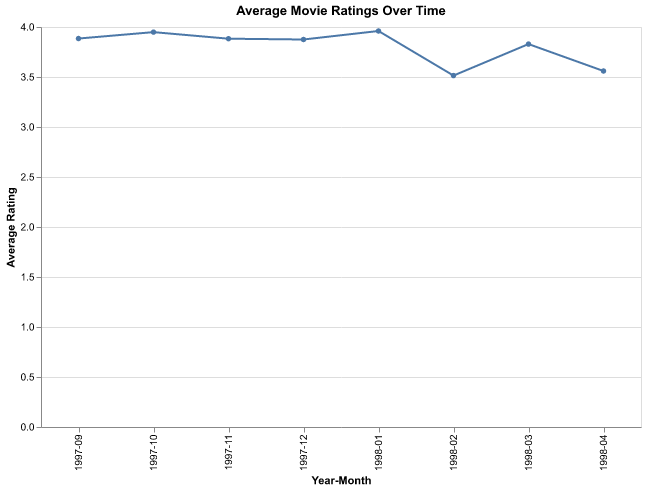

In [18]:
chart = (
    alt.Chart(time_rating)
    .mark_line(point=True)
    .encode(
        x=alt.X("year_month:O", title="Year-Month"),  # use Ordinal (O) instead of Temporal (T)
        y=alt.Y("rating:Q", title="Average Rating"),
        tooltip=["year_month", "rating:Q"]
    )
    .properties(
        title="Average Movie Ratings Over Time",
        width=600,
        height=400
    )
)

chart


**What are the 5 best-rated movies that have at least 50 ratings? At least 150 ratings?**

In [19]:
best_rated_movs = (
    df.groupby("title")
    .filter(lambda x: len(x) >= 50)
    .groupby("title")["rating"]
    .mean()
    .sort_values( ascending=False)
).reset_index()


In [20]:
best_rated_movs[:5]

,title,rating
0,"Close Shave, A (1995)",4.491071
1,Schindler's List (1993),4.466443
2,"Wrong Trousers, The (1993)",4.466102
3,Casablanca (1942),4.456790
4,Wallace & Gromit: The Best of Aardman Animatio...,4.447761


In [21]:
best_rated_movs = (
    df.groupby("title")
    .filter(lambda x: len(x) >= 150)
    .groupby("title")["rating"]
    .mean()
    .sort_values( ascending=False)
).reset_index()


In [22]:
best_rated_movs[:5]

,title,rating
0,"Close Shave, A (1995)",4.491071
1,Schindler's List (1993),4.466443
2,"Wrong Trousers, The (1993)",4.466102
3,Casablanca (1942),4.456790
4,"Shawshank Redemption, The (1994)",4.445230


**For each genre, how does the rating change as viewer age increases?**

In [23]:
age_rating = df.groupby(['genres','age']).agg({'rating':'mean'}).reset_index()

In [24]:
age_rating

,genres,age,rating
0,Action,7,3.611111
1,Action,10,4.000000
2,Action,11,3.076923
3,Action,13,3.493421
4,Action,14,3.593220
...,...,...,...
1057,unknown,26,2.500000
1058,unknown,29,3.000000
1059,unknown,33,4.000000
1060,unknown,34,1.000000


In [25]:
action_genre = age_rating[age_rating['genres'] == 'Action']

In [26]:
action_genre

,genres,age,rating
0,Action,7,3.611111
1,Action,10,4.000000
2,Action,11,3.076923
3,Action,13,3.493421
4,Action,14,3.593220
...,...,...,...
56,Action,66,3.000000
57,Action,68,3.166667
58,Action,69,3.730769
59,Action,70,3.565217


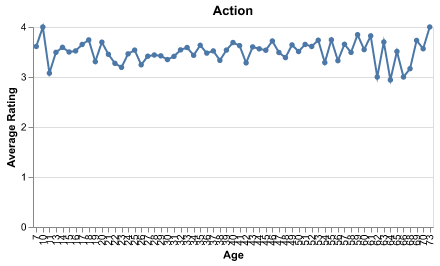

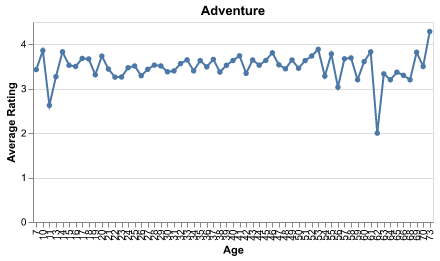

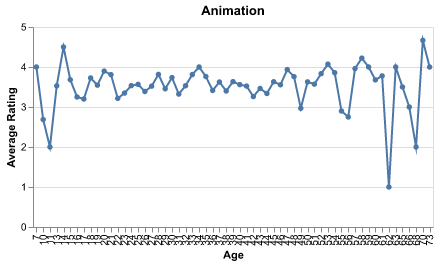

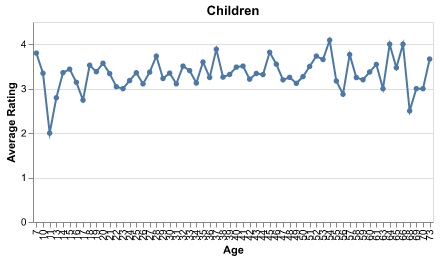

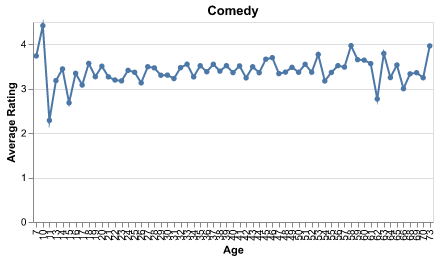

In [27]:
from IPython.display import display

for genre in age_rating['genres'].unique()[:5]: # limited to 5 cause there a lof of them
    selected_genre = age_rating[age_rating['genres'] == genre]
    chart = (
        alt.Chart(selected_genre)
        .mark_line(point=True)
        .encode(
            x=alt.X("age:O", title="Age"),
            y=alt.Y("rating:Q", title="Average Rating"),
            tooltip=["age", "rating:Q"]
        )
        .properties(
            title=genre,
            width=400,
            height=200
        )
    )
    
    display(chart)


**Plot number of ratings vs mean rating per genre. Is there a correlation between the volume of ratings and mean rating?**

In [28]:
count_vs_mean = df.groupby('title').agg(
     rating_count = ("rating","count"),
     rating_mean  = ("rating","mean")
).reset_index()
count_vs_mean["rating_mean"] = round(count_vs_mean["rating_mean"],1)

In [29]:
count_vs_mean

,title,rating_count,rating_mean
0,'Til There Was You (1997),18,2.3
1,1-900 (1994),5,2.6
2,101 Dalmatians (1996),218,2.9
3,12 Angry Men (1957),125,4.3
4,187 (1997),41,3.0
...,...,...,...
1659,Young Guns II (1990),132,2.8
1660,"Young Poisoner's Handbook, The (1995)",41,3.3
1661,Zeus and Roxanne (1997),6,2.2
1662,unknown,9,3.4


In [30]:
correlation = count_vs_mean[["rating_count", "rating_mean"]].corr()
print(correlation)

              rating_count  rating_mean
rating_count      1.000000     0.339318
rating_mean       0.339318     1.000000


positive correlation but not very high

In [31]:
dirty_df = pd.read_csv("../data/movie_ratings_EC.csv")

In [32]:
dirty_df['genres']

0                                  Comedy
1        Crime|Film-Noir|Mystery|Thriller
2                         Children|Comedy
3               Drama|Romance|War|Western
4                             Crime|Drama
                       ...               
99995                              Comedy
99996                       Comedy|Sci-Fi
99997                            Thriller
99998                     Children|Comedy
99999                             Western
Name: genres, Length: 100000, dtype: object

In [33]:
df_exploded = df.explode("genres")
#

In [34]:
df_exploded['genres'].unique()

array(['Comedy', 'Crime', 'Film-Noir', 'Mystery', 'Thriller', 'Children',
       'Drama', 'Romance', 'War', 'Western', 'Sci-Fi', 'Action',
       'Adventure', 'Musical', 'Documentary', 'Animation', 'Horror',
       'Fantasy', 'unknown'], dtype=object)

**WOW**